**Basic Imports**

In [19]:
import numpy as np
import pandas as pd
import lifelines
import matplotlib.pyplot as plt

from util_3 import load_data

from lifelines import KaplanMeierFitter as KM
from lifelines.statistics import logrank_test

- Time: days after a disease is diagnosed and the patient either dies or left the hospital's supervision.
- Event: 
    - 1 if the patient died
    - 0 if the patient was not observed to die beyond the given 'Time' (their data is censored)
    
Notice that these are the same numbers that you see in the lecture video about estimating survival.

In [2]:
df = pd.DataFrame({'Time': [10,8,60,20,12,30,15],
                   'Event': [1,0,1,1,0,1,0]
                  })
df

,Time,Event
0,10,1
1,8,0
2,60,1
3,20,1
4,12,0
5,30,1
6,15,0


**Count the number of censored patients**

In [4]:
df['Event'] == 0

0    False
1     True
2    False
3    False
4     True
5    False
6     True
Name: Event, dtype: bool

In [5]:
sum(df['Event'] == 0)

3

Patient 1, 4 and 6 were censored.

- Count how many patient records were censored

When we sum a series of booleans, `True` is treated as 1 and `False` is treated as 0.

**Count number of patients who definitely survived past time t**

This assumes that any patient who was censored died at the time of being censored ( **died immediately**).

If a patient survived past time `t`:
- Their `Time` of event should be greater than `t`.  
- Notice that they can have an `Event` of either 1 or 0.  What matters is their `Time` value.

In [8]:
t = 25
df['Time'] > t

0    False
1    False
2     True
3    False
4    False
5     True
6    False
Name: Time, dtype: bool

In [9]:
sum(df['Time'] > t)

2

**Count the number of patients who may have survived past t**

This assumes that censored patients **never die**.
- The patient is censored at any time and we assume that they live forever.
- The patient died (`Event` is 1) but after time `t`

In [11]:
t = 25
(df['Time'] > t) | (df['Event'] == 0)

0    False
1     True
2     True
3    False
4     True
5     True
6     True
dtype: bool

In [12]:
sum((df['Time'] > t) | (df['Event'] == 0))

5

**Count number of patients who were not censored before time t**

If patient was not censored before time `t`:
- They either had an event (death) before `t`, at `t`, or after `t` (any time)
- Or, their `Time` occurs after time `t` (they may have either died or been censored at a later time after `t`)

In [13]:
t = 25
(df['Time'] > t) | (df['Event'] == 1)

0     True
1    False
2     True
3     True
4    False
5     True
6    False
dtype: bool

In [14]:
sum((df['Time'] > t) | (df['Event'] == 1))

4

# Kaplan-Meier

The Kaplan Meier estimate of survival probability is:

$$
S(t) = \prod_{t_i \leq t} (1 - \frac{d_i}{n_i})
$$

- $t_i$ are the events observed in the dataset 
- $d_i$ is the number of deaths at time $t_i$
- $n_i$ is the number of people who we know have survived up to time $t_i$.

In [15]:
df = pd.DataFrame({'Time': [3,3,2,2],
                   'Event': [0,1,0,1]
                  })
df

,Time,Event
0,3,0
1,3,1
2,2,0
3,2,1


## Find those who survived up to time $t_i$

If they survived up to time $t_i$, 
- Their `Time` is either greater than $t_i$
- Or, their `Time` can be equal to $t_i$

In [16]:
t_i = 2
df['Time'] >= t_i

0    True
1    True
2    True
3    True
Name: Time, dtype: bool

## Find those who died at time $t_i$

- If they died at $t_i$:
- Their `Event` value is 1.  
- Also, their `Time` should be equal to $t_i$

In [17]:
t_i = 2
(df['Event'] == 1) & (df['Time'] == t_i)

0    False
1    False
2    False
3     True
dtype: bool

# Load the Dataset

In [20]:
data = load_data()

In [21]:
print("data shape: {}".format(data.shape))
data.head()

data shape: (80, 3)


,Stage_group,Time,Event
0,1,6,1
1,1,19,1
2,1,32,1
3,1,42,1
4,1,42,1


The column `Time` states how long the patient lived before they died or were censored.

The column `Event` says whether a death was observed or not. `Event` is 1 if the event is observed (i.e. the patient died) and 0 if data was censored.

Censorship here means that the observation has ended without any observed event.
For example, let a patient be in a hospital for 100 days at most. If a patient dies after only 44 days, their event will be recorded as `Time = 44` and `Event = 1`. If a patient walks out after 100 days and dies 3 days later (103 days total), this event is not observed in our process and the corresponding row has `Time = 100` and `Event = 0`. If a patient survives for 25 years after being admitted, their data for are still `Time = 100` and `Event = 0`.

# Censored Data

Histogram showing survival times; how long cases survived before censorship or events. 

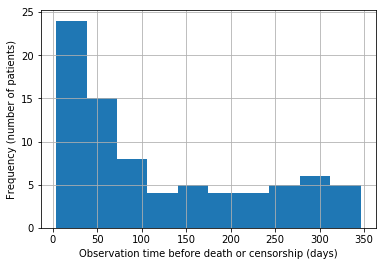

In [23]:
data.Time.hist()
plt.xlabel("Observation time before death or censorship (days)");
plt.ylabel("Frequency (number of patients)");

## Fraction of censored events

In [24]:
def frac_censored(df):
    """
    Return percent of observations which were censored.
    
    Args:
        df (dataframe): dataframe which contains column 'Event' which is 
                        1 if an event occurred (death)
                        0 if the event did not occur (censored)
    Returns:
        frac_censored (float): fraction of cases which were censored. 
    """
    result = 0.0
    
    ### START CODE HERE ###
    
    result = sum(df['Event'] == 0)/len(df)
    
    ### END CODE HERE ###
    
    return result

In [25]:
print(frac_censored(data))

0.325


**Expected Output:**
```CPP
0.325
```

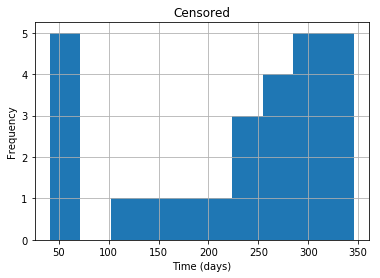

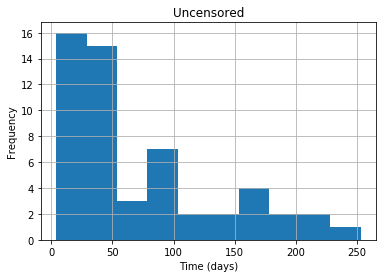

In [26]:
df_censored = data[data.Event == 0]
df_uncensored = data[data.Event == 1]

df_censored.Time.hist()
plt.title("Censored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

df_uncensored.Time.hist()
plt.title("Uncensored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

## 4. Survival Estimates

We'll now try to estimate the survival function:

$$
S(t) = P(T > t)
$$

To illustrate the strengths of Kaplan Meier, we'll start with a naive estimator of the above survival function. To estimate this quantity, we'll divide the number of people who we know lived past time $t$ by the number of people who were not censored before $t$.

Formally, let $i$ = 1, ..., $n$ be the cases, and let $t_i$ be the time when $i$ was censored or an event happened. Let $e_i= 1$ if an event was observed for $i$ and 0 otherwise. Then let $X_t = \{i : T_i > t\}$, and let $M_t = \{i : e_i = 1 \text{ or } T_i > t\}$. The estimator you will compute will be:

$$
\hat{S}(t) = \frac{|X_t|}{|M_t|}
$$


In [27]:
def naive_estimator(t, df):
    """
    Return naive estimate for S(t), the probability
    of surviving past time t. Given by number
    of cases who survived past time t divided by the
    number of cases who weren't censored before time t.
    
    Args:
        t (int): query time
        df (dataframe): survival data. Has a Time column,
                        which says how long until that case
                        experienced an event or was censored,
                        and an Event column, which is 1 if an event
                        was observed and 0 otherwise.
    Returns:
        S_t (float): estimator for survival function evaluated at t.
    """
    S_t = 0.0
    
    ### START CODE HERE ###
    
    S_t = (sum(df['Time'] > t))/(sum((df['Time'] > t) | (df['Event'] == 1)))
    
    ### END CODE HERE ###
    
    return S_t

In [28]:
print("Test Cases")

sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.Time = [5, 10, 15]
sample_df.Event = [0, 1, 0]
print("Sample dataframe for testing code:")
print(sample_df)
print("\n")

print("Test Case 1: S(3)")
print("Output: {}, Expected: {}\n".format(naive_estimator(3, sample_df), 1.0))

print("Test Case 2: S(12)")
print("Output: {}, Expected: {}\n".format(naive_estimator(12, sample_df), 0.5))

print("Test Case 3: S(20)")
print("Output: {}, Expected: {}\n".format(naive_estimator(20, sample_df), 0.0))

# Test case 4
sample_df = pd.DataFrame({'Time': [5,5,10],
                          'Event': [0,1,0]
                         })
print("Test case 4: S(5)")
print(f"Output: {naive_estimator(5, sample_df)}, Expected: 0.5")

Test Cases
Sample dataframe for testing code:
   Time  Event
0     5      0
1    10      1
2    15      0


Test Case 1: S(3)
Output: 1.0, Expected: 1.0

Test Case 2: S(12)
Output: 0.5, Expected: 0.5

Test Case 3: S(20)
Output: 0.0, Expected: 0.0

Test case 4: S(5)
Output: 0.5, Expected: 0.5


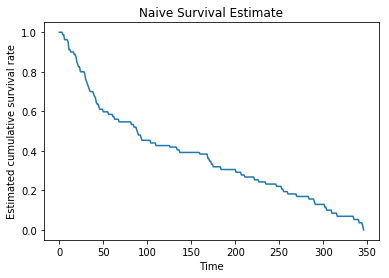

In [29]:
max_time = data.Time.max()
x = range(0, max_time+1)
y = np.zeros(len(x))
for i, t in enumerate(x):
    y[i] = naive_estimator(t, data)
    
plt.plot(x, y)
plt.title("Naive Survival Estimate")
plt.xlabel("Time")
plt.ylabel("Estimated cumulative survival rate")
plt.show()

## Comparison of naive estimator with Kaplan Meier

Next let's compare this with the Kaplan Meier estimate. In the cell below, write a function that computes the Kaplan Meier estimate of $S(t)$ at every distinct time in the dataset. 

Recall the Kaplan-Meier estimate:

$$
S(t) = \prod_{t_i \leq t} (1 - \frac{d_i}{n_i})
$$

where $t_i$ are the events observed in the dataset and $d_i$ is the number of deaths at time $t_i$ and $n_i$ is the number of people who we know have survived up to time $t_i$.

In [46]:
def HomemadeKM(df):
    """
    Return KM estimate evaluated at every distinct
    time (event or censored) recorded in the dataset.
    Event times and probabilities should begin with
    time 0 and probability 1.
    
    Example:
    
    input: 
    
         Time  Censor
    0     5       0
    1    10       1
    2    15       0
    
    correct output: 
    
    event_times: [0, 5, 10, 15]
    S: [1.0, 1.0, 0.5, 0.5]
    
    Args:
        df (dataframe): dataframe which has columns for Time
                          and Event, defined as usual.
                          
    Returns:
        event_times (list of ints): array of unique event times
                                      (begins with 0).
        S (list of floats): array of survival probabilites, so that
                            S[i] = P(T > event_times[i]). This 
                            begins with 1.0 (since no one dies at time
                            0).
    """
    # individuals are considered to have survival probability 1
    # at time 0
    event_times = [0]
    p = 1.0
    S = [p]
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get collection of unique observed event times
    observed_event_times = df.Time.unique()
  
    # sort event times
    observed_event_times = np.sort(observed_event_times)
    
    # iterate through event times
    for t in observed_event_times:
  
        # compute n_t, number of people who survive to time t
        n_t = sum(df['Time'] >= t)
  
        # compute d_t, number of people who die at time t
        d_t = sum((df['Event'] == 1) & (df['Time'] == t))
        
        p *= (1 - (d_t/n_t))
        # update p
  
        # update S and event_times (ADD code below)
        # hint: use append
        event_times.append(t)
        S.append(p)
    
    ### END CODE HERE ###
  
    return event_times, S

In [47]:
print("TEST CASES:\n")


print("Test Case 1\n")

print("Test DataFrame:")
sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.Time = [5, 10, 15]
sample_df.Event = [0, 1, 0]
print(sample_df.head())
print("\nOutput:")
x, y = HomemadeKM(sample_df)
print("Event times: {}, Survival Probabilities: {}".format(x, y))
print("\nExpected:")
print("Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]")

print("\nTest Case 2\n")

print("Test DataFrame:")

sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.loc[:, "Time"] = [2, 15, 12, 10, 20]
sample_df.loc[:, "Event"] = [0, 0, 1, 1, 1]
print(sample_df.head())
print("\nOutput:")
x, y = HomemadeKM(sample_df)
print("Event times: {}, Survival Probabilities: {}".format(x, y))
print("\nExpected:")
print("Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]")

TEST CASES:

Test Case 1

Test DataFrame:
   Time  Event
0     5      0
1    10      1
2    15      0

Output:
Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]

Expected:
Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]

Test Case 2

Test DataFrame:
   Time  Event
0     2      0
1    15      0
2    12      1
3    10      1
4    20      1

Output:
Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]

Expected:
Event times: [0, 2, 10, 12, 15, 20], Survival Probabilities: [1.0, 1.0, 0.75, 0.5, 0.5, 0.0]


## 5. Subgroup Analysis

We see that along with Time and Censor, we have a column called `Stage_group`. 
- A value of 1 in this column denotes a patient with stage III cancer
- A value of 2 denotes stage IV. 

We want to compare the survival functions of these two groups.

This time we'll use the `KaplanMeierFitter` class from `lifelines`. Run the next cell to fit and plot the Kaplan Meier curves for each group. 

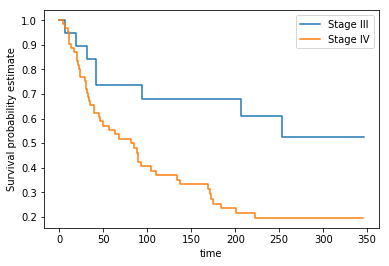

In [48]:
S1 = data[data.Stage_group == 1]
km1 = KM()
km1.fit(S1.loc[:, 'Time'], event_observed = S1.loc[:, 'Event'], label = 'Stage III')

S2 = data[data.Stage_group == 2]
km2 = KM()
km2.fit(S2.loc[:, "Time"], event_observed = S2.loc[:, 'Event'], label = 'Stage IV')

ax = km1.plot(ci_show=False)
km2.plot(ax = ax, ci_show=False)
plt.xlabel('time')
plt.ylabel('Survival probability estimate')
plt.savefig('two_km_curves', dpi=300)

Let's compare the survival functions at 90, 180, 270, and 360 days

In [49]:
survivals = pd.DataFrame([90, 180, 270, 360], columns = ['time'])
survivals.loc[:, 'Group 1'] = km1.survival_function_at_times(survivals['time']).values
survivals.loc[:, 'Group 2'] = km2.survival_function_at_times(survivals['time']).values

In [50]:
survivals

,time,Group 1,Group 2
0,90,0.736842,0.424529
1,180,0.680162,0.254066
2,270,0.524696,0.195436
3,360,0.524696,0.195436


This makes clear the difference in survival between the Stage III and IV cancer groups in the dataset. 

## Bonus: Log-Rank Test

To say whether there is a statistical difference between the survival curves we can run the log-rank test. This test tells us the probability that we could observe this data if the two curves were the same. The derivation of the log-rank test is somewhat complicated, but luckily `lifelines` has a simple function to compute it. 

Run the next cell to compute a p-value using `lifelines.statistics.logrank_test`.

In [51]:
def logrank_p_value(group_1_data, group_2_data):
    result = logrank_test(group_1_data.Time, group_2_data.Time,
                          group_1_data.Event, group_2_data.Event)
    return result.p_value

logrank_p_value(S1, S2)

0.009588929834755544